# Spectral Graph Model's frequency responses

In [1]:
#spectrome modules
from spectrome.forward import runforward
from spectrome.utils import functions, path, generate
from spectrome.brain import Brain

#generic modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [12]:
# An external custom function for re-arranging the individual connectomes to match the Desikan-Killiany atlas brain regions indexing.

def get_Julia_order():
    """Get Julia Owen's brain region ordering (specific for DK86 atlas).

    Args:

    Returns:
        permJulia (type): Brain region orders for all regions
        emptyJulia (type): Brain regions with no MEG
        cortJulia (type): Brain cortical regions.

    """
    cortJulia_lh = np.array([0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14,
                             15, 17, 16, 18, 19, 20, 21, 22, 23, 24, 25,
                             26, 27, 28, 29, 30, 31, 5, 32, 33, 9])
    qsubcort_lh = np.array([0, 40, 36, 39, 38, 37, 35, 34, 0])
    qsubcort_rh = qsubcort_lh + 34 + 1
    cortJulia = np.concatenate([cortJulia_lh, 34 + cortJulia_lh])
    cortJulia_rh = cortJulia_lh + 34 + 7
    permJulia = np.concatenate([cortJulia_lh, cortJulia_rh,
                                qsubcort_lh, qsubcort_rh])
    emptyJulia = np.array([68, 77, 76, 85])
    return permJulia, emptyJulia, cortJulia

Create spectrome brain object with HCP connectomes:

In [2]:
brain = Brain.Brain()

hcp_dir = path.get_data_path() # get path to data folder where hcp files are
brain.add_connectome(hcp_dir)

# re-ordering for DK atlas and normalizing the connectomes:
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
print(brain.reducedConnectome.shape) # size of our connectome, 86 parcellations according to Desikan-Killiany atlas

# Properties of HCP connectome:
print("Number of vertices: ", brain.connectome.shape[0])
print("Number of edges: ", np.count_nonzero(np.triu(brain.reducedConnectome)))
print("HCP weight mean: ", np.mean(np.mean(brain.reducedConnectome)))
print("HCP weight std: ", np.std(brain.reducedConnectome))
# we will use these numbers later for random connectome generation.

(86, 86)
Number of vertices:  86
Number of edges:  3418
HCP weight mean:  18.08254396427022
HCP weight std:  44.19650857621448


first run spectral graph model to obtain eigenmodes of complex laplacian:

In [3]:
#define frequency bins of interest:
fmin = 2
fmax = 45
fvec = np.linspace(fmin,fmax,40)

In [4]:
## Use optmized parameters or not
## Skip this cell if you want to use default parameters.

## load optimized parameters:
opparam = loadmat(hcp_dir + '/SCFC_opparam_HCP.mat')
brain.ntf_params['tau_e'] = opparam['output']['param'][0,1][0]
brain.ntf_params['tau_i'] = opparam['output']['param'][0,1][1]
brain.ntf_params['alpha'] = opparam['output']['param'][0,1][2]
brain.ntf_params['speed'] = opparam['output']['param'][0,1][3]
brain.ntf_params['gei'] = opparam['output']['param'][0,1][4]
brain.ntf_params['gii'] = opparam['output']['param'][0,1][5]
brain.ntf_params['tauC'] = opparam['output']['param'][0,1][6]
print(brain.ntf_params)
optimized_parameters = brain.ntf_params

{'tau_e': array([0.01193486]), 'tau_i': array([0.00741637]), 'alpha': array([0.9670233]), 'speed': array([14.47905581]), 'gei': array([3.95527275]), 'gii': array([1.79503011]), 'tauC': array([0.00875784])}


In [5]:
# run sgm:
model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_forward(brain, optimized_parameters, fvec)
print(model_spectrum.shape)

(86, 40)


### Frequency dependent behavior of complex eigenmodes from HCP connectome:

Text(0, 0.5, 'Frequency (Hz)')

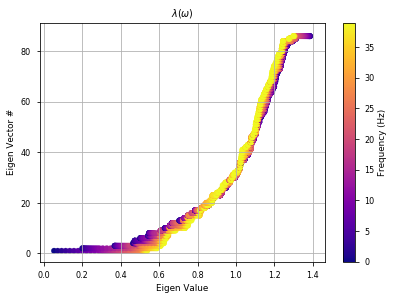

In [6]:
# define matplotlib style:
plt.style.use('seaborn-paper')

# Lambda(Omega) Plot with default parameters
cmap = plt.get_cmap('plasma')
fig_lomega, ax_lomega = plt.subplots()
for i in np.arange(0,eigvalues.shape[1]):
    fig_scatter = ax_lomega.scatter(np.abs(eigvalues[:,i]),np.ones(eigvalues.shape[0])*(i+1),
                     c = np.arange(0,fvec.size), cmap = cmap)
    
ax_lomega.grid(True)
clb = fig_lomega.colorbar(fig_scatter, ax = ax_lomega)
ax_lomega.set_xlabel('Eigen Value')
ax_lomega.set_ylabel('Eigen Vector #')
ax_lomega.set_title(r'$\lambda(\omega)$')
clb.ax.set_ylabel('Frequency (Hz)')

#save figure?
#plt.savefig('eigen_spectrum.png', dpi = 300, format = 'png')

### Magnitude response of eigenmodes from different types of connectomes:

In [61]:
## individual connectome:
ind_data = loadmat(hcp_dir + '/individual_subjects.mat')
C_ind = ind_data['A_all_subjs_final'][:,:,0] # select a single subject's connectome
perm_Julia, empty_Julia, cort_Julia = get_Julia_order()
C_ind = C_ind[perm_Julia,:][:,perm_Julia]
C_ind[empty_Julia,:] = 0
C_ind[:,empty_Julia] = 0
# create brain object
ind_brain = Brain.Brain()
ind_brain.add_connectome(hcp_dir)
ind_brain.connectome = C_ind
# re-ordering for DK atlas and normalizing the connectomes:
ind_brain.reorder_connectome(ind_brain.connectome, ind_brain.distance_matrix)
ind_brain.bi_symmetric_c()
ind_brain.reduce_extreme_dir()
_, ind_resp, _, _ = runforward.run_forward(ind_brain, optimized_parameters, fvec)
ind_magdb = functions.mag2db(np.abs(np.transpose(ind_resp[:,0:60])))

## uniform connectome:
uni_brain = Brain.Brain()
uni_brain.add_connectome(hcp_dir)
uni_brain.reducedConnectome = generate.random_Cij_und(V = 86, E = 86**2) # 86x86 random matrix with no sparsity
_, uni_resp, _, _ = runforward.run_forward(uni_brain, optimized_parameters, fvec)
uni_magdb = functions.mag2db(np.abs(np.transpose(uni_resp[:,0:60])))

## random connectome with no sparsity:
C = generate.random_Cij_und(V = 86, E = 86**2) # 86x86 random matrix with no sparsity
C = generate.add_weights(C,u = 18, s = 44) # the mean and std of hcp template connectome
# Use C
r100_brain = Brain.Brain()
r100_brain.add_connectome(hcp_dir)
r100_brain.reducedConnectome = C
_, r100_resp, _, _ = runforward.run_forward(r100_brain, optimized_parameters, fvec)
r100_magdb = functions.mag2db(np.abs(np.transpose(r100_resp[:,0:60])))

## random with 75% sparsity:
C = generate.random_Cij_und(V = 86, E = np.rint((86**2)*(1-0.75)).astype(int)) # 86x86 random matrix with 75% sparsity
C = generate.add_weights(C,u = 18, s = 44)
# Use C
r75_brain = Brain.Brain()
r75_brain.add_connectome(hcp_dir)
r75_brain.reducedConnectome = C
_, r75_resp, _, _ = runforward.run_forward(r75_brain, optimized_parameters, fvec)
r75_magdb = functions.mag2db(np.abs(np.transpose(r75_resp[:,0:60])))

## random with 95% sparsity:
C = generate.random_Cij_und(V = 86, E = np.rint((86**2)*(1-0.95)).astype(int)) # 86x86 random matrix with 75% sparsity
C = generate.add_weights(C,u = 18, s = 44)
# Use C
r95_brain = Brain.Brain()
r95_brain.add_connectome(hcp_dir)
r95_brain.reducedConnectome = C
_, r95_resp, _, _ = runforward.run_forward(r95_brain, optimized_parameters, fvec)
r95_magdb = functions.mag2db(np.abs(np.transpose(r95_resp[:,0:60])))

Plot frequency spectra first:

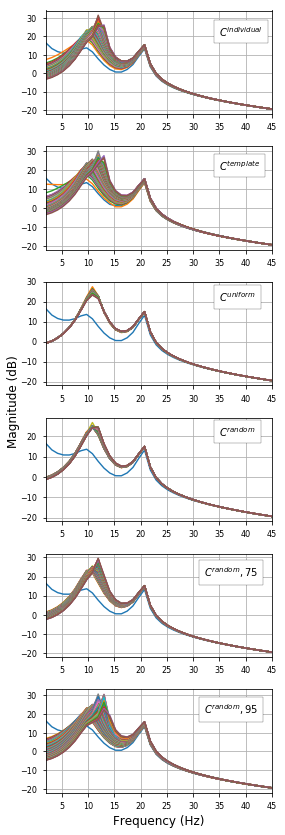

In [90]:
%matplotlib inline

font_size = 10
# subplot with 6 rows and 1 column:
with plt.style.context('seaborn-paper'):
    freqs, (f1, f2, f3, f4, f5, f6) = plt.subplots(6,1,figsize = (4.5, 12.0))
    f1.plot(fvec, functions.mag2db(np.abs(ind_resp)))
    f1.autoscale(enable=True, axis='x', tight=True)
    f1.text(35,20, r'$C^{individual}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f1.grid(True)

    f2.plot(fvec, functions.mag2db(np.abs(freq_response)))
    f2.autoscale(enable=True, axis='x', tight=True)
    f2.text(35,20, r'$C^{template}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f2.grid(True)
    
    f3.plot(fvec, functions.mag2db(np.abs(uni_resp)))
    f3.autoscale(enable=True, axis='x', tight=True)
    f3.text(35,20, r'$C^{uniform}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f3.grid(True)
    
    f4.plot(fvec, functions.mag2db(np.abs(r100_resp)))
    f4.autoscale(enable=True, axis='x', tight=True)
    f4.text(35,20, r'$C^{random}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f4.grid(True)
    
    f5.plot(fvec, functions.mag2db(np.abs(r75_resp)))
    f5.autoscale(enable=True, axis='x', tight=True)
    f5.text(32,20, r'$C^{random}, 75% sparsity$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f5.grid(True)
    
    f6.plot(fvec, functions.mag2db(np.abs(r95_resp)))
    f6.autoscale(enable=True, axis='x', tight=True)
    f6.text(32,20, r'$C^{random}, 95% sparsity$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    f6.grid(True)
    f6.set_xlabel('Frequency (Hz)', fontsize = 12)
    
    freqs.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel('Magnitude (dB)', fontsize = 12)
    
    plt.tight_layout()
    
    # save figure?
    #plt.savefig('freq_spectrum.png', dpi = 300, format = 'png')

Plotting heatmap of eigenmodes' magnitude per frequency:

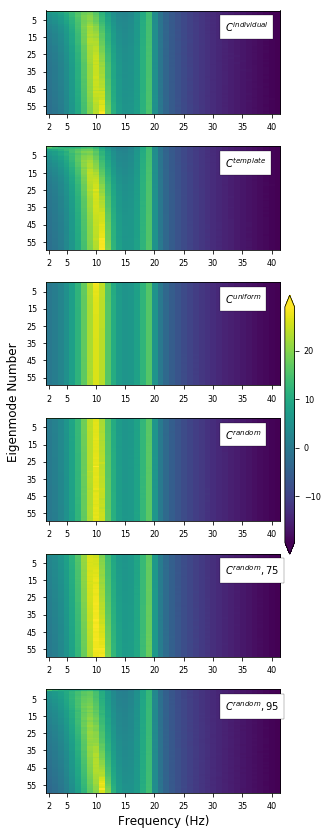

In [91]:
with plt.style.context('seaborn-paper'):
    hm, (m1,m2,m3,m4,m5,m6) = plt.subplots(6,1,figsize=(4.5,12.0))
    img = m1.imshow(ind_magdb,aspect = 'auto')
    m1.set_yticks(np.arange(5,60,10))
    m1.xaxis.set_major_locator(plt.FixedLocator([0, 3, 8, 13, 18, 23, 28, 33, 38])) # shift axis because our frequency bin begins at 2 Hz
    m1.set_xticklabels([2,5,10,15,20,25,30,35,40]) # re-set axis labels
    m1.text(30,12, r'$C^{individual}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m2.imshow(functions.mag2db(np.abs(np.transpose(freq_response[:,0:60]))),aspect = 'auto')
    m2.set_yticks(np.arange(5,60,10))
    m2.xaxis.set_major_locator(plt.FixedLocator([0, 3, 8, 13, 18, 23, 28, 33, 38])) # shift axis because our frequency bin begins at 2 Hz
    m2.set_xticklabels([2,5,10,15,20,25,30,35,40]) # re-set axis labels
    m2.text(30,12, r'$C^{template}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m3.imshow(uni_magdb,aspect = 'auto')
    m3.set_yticks(np.arange(5,60,10))
    m3.xaxis.set_major_locator(plt.FixedLocator([0, 3, 8, 13, 18, 23, 28, 33, 38])) # shift axis because our frequency bin begins at 2 Hz
    m3.set_xticklabels([2,5,10,15,20,25,30,35,40]) # re-set axis labels
    m3.text(30,12, r'$C^{uniform}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m4.imshow(r100_magdb,aspect = 'auto')
    m4.set_yticks(np.arange(5,60,10))
    m4.xaxis.set_major_locator(plt.FixedLocator([0, 3, 8, 13, 18, 23, 28, 33, 38])) # shift axis because our frequency bin begins at 2 Hz
    m4.set_xticklabels([2,5,10,15,20,25,30,35,40]) # re-set axis labels
    m4.text(30,12, r'$C^{random}$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m5.imshow(r75_magdb,aspect = 'auto')
    m5.set_yticks(np.arange(5,60,10))
    m5.xaxis.set_major_locator(plt.FixedLocator([0, 3, 8, 13, 18, 23, 28, 33, 38])) # shift axis because our frequency bin begins at 2 Hz
    m5.set_xticklabels([2,5,10,15,20,25,30,35,40]) # re-set axis labels
    m5.text(30,12, r'$C^{random}, 75% sparsity$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    
    m6.imshow(r95_magdb,aspect = 'auto')
    m6.set_yticks(np.arange(5,60,10))
    m6.xaxis.set_major_locator(plt.FixedLocator([0, 3, 8, 13, 18, 23, 28, 33, 38])) # shift axis because our frequency bin begins at 2 Hz
    m6.set_xticklabels([2,5,10,15,20,25,30,35,40]) # re-set axis labels
    m6.text(30,12, r'$C^{random}, 95% sparsity$', bbox = {'facecolor':'white','pad':5}, fontsize = font_size)
    m6.set_xlabel('Frequency (Hz)', fontsize = 12)
    
    cbar_ax = hm.add_axes([0.95, 0.35, 0.03, 0.3])
    cb = hm.colorbar(img, cax = cbar_ax, extend = 'both')
    hm.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel('Eigenmode Number', fontsize = 12)

    plt.tight_layout()
    
    #save figure?
    #plt.savefig('spectrum_heatmap.png', dpi = 300, format = 'png')